# Plot Adsorption Isotherms

This notebook produces the isotherm plots that will go in the paper.

### TODO:
- consider making a plotting function since most of the plots are pretty much the same
- consider making the data_marker a Dict of tuples: (Xe, sim) => "X", (Xe, exp) => "v" 

In [1]:
using PorousMaterials
using FileIO
using JLD2
using CSV
using DataFrames
using PyPlot
using PyCall

# PyPlot.matplotlib.style.use("Solarize_Light2")
PyPlot.matplotlib.style.use("ggplot")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16; #16;

In [2]:
set_path_to_data(joinpath(pwd(), "../../data"))

general data folder: /home/ng/DTRA/figures/isotherm_plots/../../data
	crystal structures (.cif, .cssr): /home/ng/DTRA/figures/isotherm_plots/../../data/crystals
	force field files (.csv): /home/ng/DTRA/figures/isotherm_plots/../../data/forcefields
	molecule input files: /home/ng/DTRA/figures/isotherm_plots/../../data/molecules
	simulation output files: /home/ng/DTRA/figures/isotherm_plots/../../data/simulations
	grids (.cube): /home/ng/DTRA/figures/isotherm_plots/../../data/grids


In [3]:
# whtat properties do you want to put into the .csv?
props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

adsorbates = ["Xe", "Kr", "Ar"]

pmin  = -3 # minimum pessure in log10, units: bar
pmax  = 1.0 # maximum pressure (actual value), units: bar
nstep = 25 # number of intervals in pressure range

sim_params = Dict("adsorbates" => adsorbates,
                  "temp"       => 298.0, # units: K
                  "molecules"  => Dict(zip(adsorbates, Molecule.(adsorbates))),
                  "pressures"  => 10 .^ range(pmin, stop=log10(pmax), length=nstep),
                  "ljff"       => LJForceField("UFF"),
                  "n_burn"     => 50000,
                  "n_sample"   => 50000
                  )

Dict{String, Any} with 7 entries:
  "adsorbates" => ["Xe", "Kr", "Ar"]
  "ljff"       => Force field: UFF…
  "n_burn"     => 50000
  "pressures"  => [0.001, 0.00133352, 0.00177828, 0.00237137, 0.00316228, 0.004…
  "temp"       => 298.0
  "molecules"  => Dict{String, Molecule{Cart}}("Kr"=>Molecule species: Kr…
  "n_sample"   => 50000

## Data Retrieval Functions

#### Experimental

In [4]:
function experimental_isotherm_data(adsorbate::String, fgroup::String="")
    # define data file name
    filename = "NiPyC2" 
    if ! isempty(fgroup)
        filename *= "-" * fgroup
    end
    filename *= "_" * adsorbate * "_T_298.csv"
    @info filename
    # define path to data file
    wheres_exptl_data = joinpath(PorousMaterials.PATH_TO_DATA,
        "experimental_isotherm_data", filename)
    
    # read data file into a DataFrame
    df_exptl_data = CSV.read(wheres_exptl_data, DataFrame)
    # rename to adsorption column for consistency 
    rename!(df_exptl_data, Symbol("loading (mmol/g)") => Symbol("⟨N⟩ (mmol/g)"))
    
    # ignore desortion
    desorp_onset = argmax(df_exptl_data[!, Symbol("pressure (bar)")]) # onset of desorption
    df_exptl_data = df_exptl_data[1:desorp_onset, [Symbol("pressure (bar)"), Symbol("⟨N⟩ (mmol/g)")]]
    
    # add a point at the origin
    push!(df_exptl_data, [0.0, 0.0])
    
    # sort in order of increasing pressure
    sort!(df_exptl_data, Symbol("pressure (bar)"))
    return df_exptl_data
end

experimental_isotherm_data (generic function with 2 methods)

In [5]:
# experimental_isotherm_data("Xe")

#### Simulation

In [6]:
function read_sim_data(props::Array{String, 1}, xtal::Crystal, 
                        gas::Molecule{Cart}, temp::Float64, ljff::LJForceField, 
                        pressures::Array{Float64}, nburn::Int64, nsample::Int64)
    press = [[p] for p in pressures]
    df_sim = isotherm_sim_results_to_dataframe(props, xtal, [gas], temp, press, ljff, nburn, nsample)
    push!(df_sim, [[0.0], [0.0], [0.0]]) ### add point at origin ###
    sort!(df_sim, Symbol("pressure (bar)"))
    return df_sim
end

# create a second method that is easier to implement
function read_sim_data(props::Array{String, 1}, gas::String, params::Dict{String, Any})
    @assert (gas in params["adsorbates"])
    gas = Molecule(gas)
    return read_sim_data(props, params["xtal"], gas, params["temp"],
                         params["ljff"], params["pressures"], params["n_burn"], params["n_sample"])
end

###
#  account for change in unit cell volume when plotting adsorbates/unit_cell comparison
###
function adsorption_scale_factor(mof::String)
    xtal = Crystal(mof)
    strip_numbers_from_atom_labels!(xtal)
#         @assert length(frameworks) == 1
    adsorption_scale_factor = 6.02214 * crystal_density(xtal) * xtal.box.Ω * 10^(-7)
    return adsorption_scale_factor
end

adsorption_scale_factor (generic function with 1 method)

### Ni(PyC)2 adsorption isotherm plot

In [7]:
adsorbate_to_color = Dict(zip(adsorbates, ["C0", "C1", "C2"]))

# adsorbate_to_marker = Dict(zip(["Xe", "Kr", "Ar"], ["v", "D", "h"]))

###
#  IDEAL!! Make THIS A TUPLE: (Xe, sim) => "X", (Xe, exp) => "v"
data_marker = Dict(zip([1, 2, 3, 4, 5, 6],["X", "v", "P", "D", "*", "h"]))

# labels for each MOF
# mof_to_marker = Dict(zip(frameworks, ["x", "s", "P", "o", "*", ">"]))
# mof_to_color = Dict(zip(frameworks, ["C$i" for i = 1:length(frameworks)]))

# labels for each experimental data set
labels_exp = Dict("Xe" => "Xe experiment", 
                  "Kr" => "Kr experiment", 
                  "Ar" => "Ar experiment")

exp_data_to_marker = Dict(zip(["", "NH2"], ["v", "D"]))
exp_data_to_color = Dict(zip(["", "NH2"], ["g", "b"]))

# labels for adsorbate used
labels_gas = Dict("Xe" => "Xe simulation",
                  "Kr" => "Kr simulation",
                  "Ar" => "Ar simulation")

Dict{String, String} with 3 entries:
  "Kr" => "Kr simulation"
  "Ar" => "Ar simulation"
  "Xe" => "Xe simulation"

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/ng/.julia/dev/PorousMaterials/src/crystal.jl:426
┌ Info: NiPyC2_Xe_T_298.csv
└ @ Main In[4]:8
┌ Info: NiPyC2_Kr_T_298.csv
└ @ Main In[4]:8
┌ Info: NiPyC2_Ar_T_298.csv
└ @ Main In[4]:8


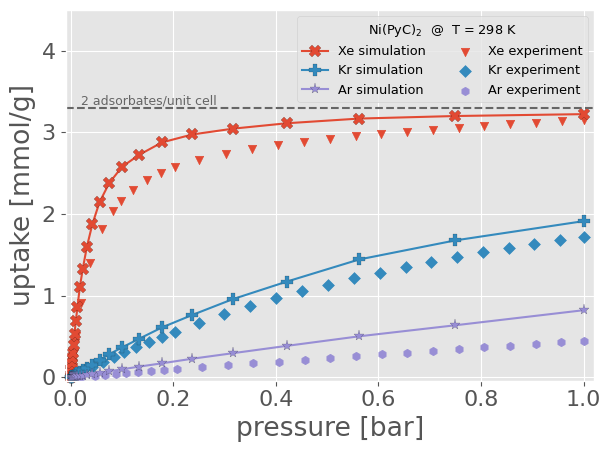

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/ng/.julia/dev/PorousMaterials/src/crystal.jl:426


In [8]:
# frameworks to plot
frameworks = ["NiPyC2_experiment.cif"]
labels_mof = Dict(zip(frameworks, ["Ni(PyC)"*L"_2"]))

###
# Create Figure
###
fig, ax1 = plt.subplots() # create the figure as a subplot

# create an array for plot handles
plts = Array{Any, 1}(undef, 6)
nn = 0 # plot index

# create an empty plot object to place T=298 K in legend
# plts[nn] = ax1.scatter([], [], label="T = 298 K", marker=data_marker[nn], color="")


########
sim_params["xtal"] = Crystal(frameworks[1])

for gas in adsorbates
    for mof in frameworks
        # increment plot index
        nn += 1 

        # load in simulation data
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        
        # plot uptake mmol/g 
        plts[nn] = ax1.plot(df_sim[:, Symbol("pressure (bar)")], 
                            df_sim[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_gas[gas],
                            marker=data_marker[nn],
                            markersize=8,
                            markeredgecolor="black",
                            markeredgewidth=0.1,
                            color=adsorbate_to_color[gas],
                            clip_on=false)
    end
    # increment plot index
    nn += 1 
    
    # reset ads_scale_factor
    ads_scale_factor = 1.0 
    
    # load exptl data
    df_exp = experimental_isotherm_data(gas) # default fgroup=""
    # plot exptl data
    plts[nn] = ax1.scatter(df_exp[:, Symbol("pressure (bar)")], 
                            df_exp[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_exp[gas],
                            marker=data_marker[nn],
                            color=adsorbate_to_color[gas],
                            clip_on=false)
end

ads_scale_factor = adsorption_scale_factor(frameworks[1])

# title("Ni(PyC)" * L"$_2$" * " simulation vs. experiment")
legend(loc="upper right", fontsize="xx-small",
       title="Ni(PyC)" * L"$_2$" * "  @  T = 298 K", 
       title_fontsize="xx-small", ncol=2)

ax1.grid("on")
ax1.set_xlabel("pressure [bar]")
ax1.set_ylabel("uptake [mmol/g]")

ymin = -0.04
ymax = 4.5
ax1.set_ylim(ymin, ymax)


xmin = -0.01
xmax = sim_params["pressures"][end] + 0.02
ax1.set_xlim(xmin, xmax)

ax1.axhline(y=2/ads_scale_factor, linestyle="--", color="0.4")
ax1.text(0.02, 2/ads_scale_factor+0.04, "2 adsorbates/unit cell", color="0.4", fontsize=9)

tight_layout()
savefig("NiPyC2_isotherms_sim_vs_exp_UFF.png", dpi=300, format="png")
savefig("NiPyC2_isotherms_sim_vs_exp_UFF.pdf", dpi=300, format="pdf")

### Ni(PyC-m-NH2)2 Adsorption Isotherm Plot

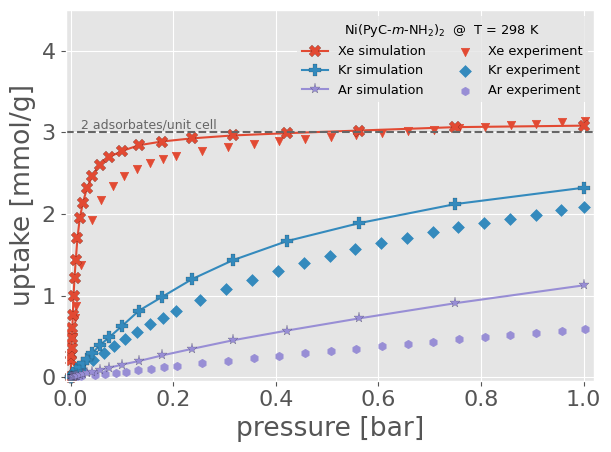

┌ Info: NiPyC2-mNH2_Xe_T_298.csv
└ @ Main In[4]:8
┌ Info: NiPyC2-mNH2_Kr_T_298.csv
└ @ Main In[4]:8
┌ Info: NiPyC2-mNH2_Ar_T_298.csv
└ @ Main In[4]:8


In [9]:
# frameworks to plot
frameworks = ["NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif"]

sim_params["xtal"] = Crystal(frameworks[1])

labels_mof = Dict(zip(frameworks, ["Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2"]))

###
# Create Figure
###
fig, ax1 = plt.subplots() # create the figure as a subplot

# create an array for plot handles
plts = Array{Any, 1}(undef, 6)
nn   = 0 # plot index

sim_params

for gas in adsorbates
    for mof in frameworks
        # increment plot index
        nn += 1 

        # load in simulation data
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        
        # plot uptake mmol/g 
        plts[nn] = ax1.plot(df_sim[:, Symbol("pressure (bar)")], 
                            df_sim[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_gas[gas],
                            marker=data_marker[nn],
                            markersize=8,
                            markeredgecolor="black",
                            markeredgewidth=0.1,
                            color=adsorbate_to_color[gas],
                            clip_on=false)
    end
    # increment plot index
    nn += 1 
    
    # load exptl data
    df_exp = experimental_isotherm_data(gas, "mNH2") # default fgroup=""
    # plot exptl data
    plts[nn] = ax1.scatter(df_exp[:, Symbol("pressure (bar)")], 
                            df_exp[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_exp[gas],
                            marker=data_marker[nn],
                            color=adsorbate_to_color[gas],
                            clip_on=false)
end

# divided by two to account for 2x1x1 cell replication before DFT relaxation
ads_scale_factor = adsorption_scale_factor(frameworks[1])/2

# title("Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2", fontsize="xx-small")
legend(loc="best", fontsize="xx-small",
       title="Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2" *"  @  T = 298 K",
       title_fontsize="xx-small", ncol=2, edgecolor="none")

ax1.grid("on")
ax1.set_xlabel("pressure [bar]")
ax1.set_ylabel("uptake [mmol/g]")

ymin = -0.04
ymax = 4.5
ax1.set_ylim(ymin, ymax)


xmin = -0.01
xmax = sim_params["pressures"][end] + 0.02
ax1.set_xlim(xmin, xmax)

ax1.axhline(y=2/ads_scale_factor, linestyle="--", color="0.4")
ax1.text(0.02, 2/ads_scale_factor+0.04, "2 adsorbates/unit cell", color="0.4", fontsize=9)

tight_layout()
savefig("mNH2-NiPyC2_isotherms_sim_vs_exp_UFF.png", dpi=300, format="png")
savefig("mNH2-NiPyC2_isotherms_sim_vs_exp_UFF.pdf", dpi=300, format="pdf")

#### Single Net Ni(PyC-m-NH2)2 Adsorption Isotherm Plot

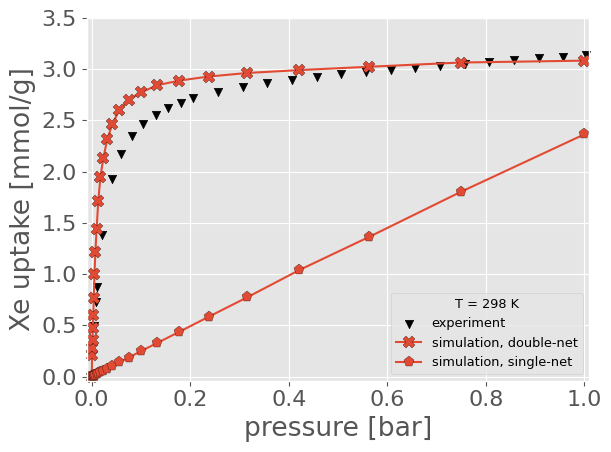

┌ Info: NiPyC2-mNH2_Xe_T_298.csv
└ @ Main In[4]:8


In [10]:
data_marker = Dict(zip([1, 2, 3], ["v", "X", "p"]))

net_type = ["doubble net", "single net"]
# net_type = ["Pn", "P21"]

# frameworks to plot
frameworks = ["NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif",
              "NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax_comp1.cif"]
# frameworks = ["Pn_Ni-PyC-NH2.cif", "P21-n_Ni-PyC-NH2.cif"]

crystals = Crystal.(frameworks, remove_duplicates=true)

labels_mof = Dict(zip(frameworks, 
                  ["Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2", 
                   "Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2"]))

###
# Create Figure
###
fig, ax1 = plt.subplots() # create the figure as a subplot

# create an array for plot handles
plts = Array{Any, 1}(undef, 6)
nn   = 0 # plot index

for gas in ["Xe"]
    # increment plot index
    nn += 1 
    
    # load exptl data
    df_exp = experimental_isotherm_data(gas, "mNH2") # default fgroup=""
    # plot exptl data
    plts[nn] = ax1.scatter(df_exp[:, Symbol("pressure (bar)")], 
                            df_exp[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_exp[gas],
                            marker=data_marker[nn],
                            color="k",
                            clip_on=false)
    
    for (i, mof) in enumerate(crystals)
        # increment plot index
        nn += 1
        
        # needed to get isothem data
        sim_params["xtal"] = mof
        
        # load in simulation data
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        
        # plot uptake mmol/g 
        plts[nn] = ax1.plot(df_sim[:, Symbol("pressure (bar)")], 
                            df_sim[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_gas[gas] * net_type[i],
                            marker=data_marker[nn],
                            markersize=8,
                            markeredgecolor="black",
                            markeredgewidth=0.2,
                            color=adsorbate_to_color[gas],
                            clip_on=false)
    end
end

# title("Single Net Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2", fontsize="xx-small")


legend(title="T = 298 K", title_fontsize="xx-small",
        (plts[1], plts[2][1], plts[3][1]),
        ["experiment", "simulation, double-net", "simulation, single-net"],
        loc="lower right", fontsize="xx-small")

ax1.grid("on")
ax1.set_xlabel("pressure [bar]")
ax1.set_ylabel("Xe uptake [mmol/g]")

ymin = -0.04
ymax = 3.5
ax1.set_ylim(ymin, ymax)


xmin = -0.01
xmax = sim_params["pressures"][end] + 0.01
ax1.set_xlim(xmin, xmax)

tight_layout()
savefig("Single_Net_mNH2-NiPyC2_isotherms_sim_vs_exp_UFF.png", dpi=300, format="png")
savefig("Single_Net_mNH2-NiPyC2_isotherms_sim_vs_exp_UFF.pdf", dpi=300, format="pdf")

## TODO: FIX THIS PLOT

### Compare Ni(PyC)2 isotherms to DFT relaxed isotherms 

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To afrain from this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ PorousMaterials /home/ng/.julia/dev/PorousMaterials/src/crystal.jl:426
┌ Info: NiPyC2_Xe_T_298.csv
└ @ Main In[4]:8


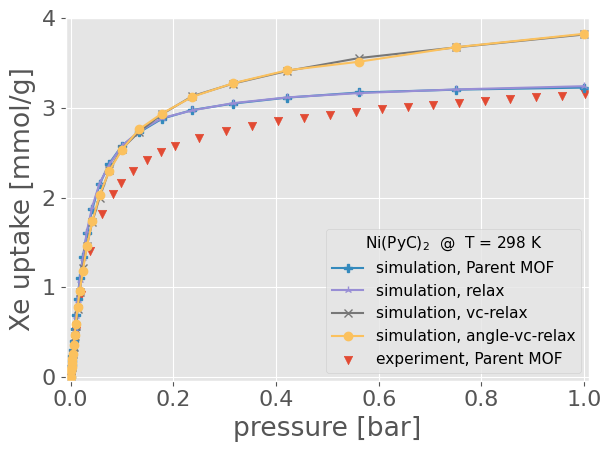

In [11]:
frameworks = ["NiPyC2_experiment.cif", 
              "NiPyC2_relax.cif",
              "NiPyC2_vc-relax.cif", 
              "NiPyC2_pbesol-angle-vc-relax.cif"]

xtals = [Crystal(f) for f in frameworks]
[strip_numbers_from_atom_labels!(xtals[i]) for i in 1:length(xtals)]

labels_mof = Dict(zip(xtals, ["Parent MOF", 
                              "relax",
                              "vc-relax", 
                              "angle-vc-relax"]))

mof_to_marker = Dict(zip(xtals, ["P", "2", "x", "o", "*", ">"]))
mof_to_color  = Dict(zip(xtals, ["C1", "C2", "C3", "C4"]))

adsorption_per_unit_cell = false
ads_scale_factor = 1.0

if adsorption_per_unit_cell
    ads_scale_factor = adsorption_scale_factor(frameworks[1])
    xtal = Crystal(frameworks[1])
    strip_numbers_from_atom_labels!(xtal)
#     @assert length(frameworks) == 1
#     adsorption_scale_factor = 6.02214 * crystal_density(xtal) * xtal.box.Ω * 10^(-7)
end


###
# make figure
###
figure()
for gas in ["Xe"]
    for mof in xtals
        sim_params["xtal"] = mof
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        plot(df_sim[:, Symbol("pressure (bar)")], 
                df_sim[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
                label="simulation, " * labels_mof[mof], 
                marker=mof_to_marker[mof],
                color=mof_to_color[mof])
    end
    
    df_exp = experimental_isotherm_data(gas)
    scatter(df_exp[:, Symbol("pressure (bar)")], 
            df_exp[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
            label= "experiment, " * "Parent MOF", 
            marker="v", 
            color="C0")
end

legend(loc="best", fontsize="x-small", 
       title="Ni(PyC)" * L"$_2$" * "  @  T = 298 K",
       title_fontsize="x-small")

# axis bounds
xmin = -0.01
xmax = sim_params["pressures"][end] + 0.01
xlim(xmin, xmax)
ymin = -0.04
ymax = 4
ylim(ymin, ymax)
# labels
xlabel("pressure [bar]")
if adsorption_per_unit_cell
    ylabel("uptake [atoms/unit cell]")
else
    ylabel("Xe uptake [mmol/g]")
    
end

grid("on")
tight_layout()
savefig("NiPyC2_DFT_isotherms_with_UFF.png", dpi=300, format="png")
savefig("NiPyC2_DFT_isotherms_with_UFF.pdf", dpi=300, format="pdf")
# savefig("NiPyC2_isotherms_uptake_per_unit_cell_with_$ffield.pdf", dpi=300, format="pdf")